In [38]:
import pandas as pd
import numpy as np
import re
import string
import stopwords
import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import LatentDirichletAllocation as LDiA
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

## Daten laden

In [2]:
# load text-data and labels
df = pd.read_json("testset.json")
df = df[["transcript", "gattung"]].copy()
df["gattung"] = df["gattung"].apply(lambda x: ' '.join(x))

In [3]:
# load and add embeddings
embeddings = pd.read_json("embeddings.json")
df["embedding"] = embeddings.apply(lambda row: ', '.join(row.astype(str)), axis=1)

In [4]:
df.head()

,transcript,gattung,embedding
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,"0.015333812683820001, 0.021696707233786, -0.07..."
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,"0.033938158303499, -0.058570936322212004, -0.0..."
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,"0.08172919601202, -0.06428052484989101, 0.0208..."
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,"0.045513272285461, 0.023429902270436002, -0.06..."
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,"0.034393869340419006, -0.038432110100984004, -..."


## EDA & Preprocessing

In [5]:
df.describe(include='object')

,transcript,gattung,embedding
count,1361,1361,1361
unique,1344,8,1344
top,,Statement,"-0.030148252844810004, -0.005122783593833001, ..."
freq,18,200,18


In [6]:
# are there items without genre value
balance_counts = df.groupby("gattung")["gattung"].agg("count")
balance_counts 

gattung
                              1
Bericht                     194
Bericht in Interviewform    200
Glosse                      191
Interview                   182
Reportage                   198
Statement                   200
Umfrage                     195
Name: gattung, dtype: int64

Die Fehlende Gattung ist ein Statement, das wird hier korrigiert

In [7]:
index = df[df["gattung"] == ""].index.tolist()
df.loc[index,["gattung"]] = "Statement"

In [8]:
balance_counts = df.groupby("gattung")["gattung"].agg("count")
balance_counts 

gattung
Bericht                     194
Bericht in Interviewform    200
Glosse                      191
Interview                   182
Reportage                   198
Statement                   201
Umfrage                     195
Name: gattung, dtype: int64


Hier werden einfach nur Dinge gezählt:

In [9]:
def word_count(text):
    return len(text.split(" "))

def char_count(text):
    return len(text)

def avr_sentence_length(text):
    sentences = text.split(".")
    lengths = [len(sentence) for sentence in sentences]
    mean = np.asarray(lengths).mean().round(2)
    return mean

df["word_count"] = df["transcript"].apply(word_count)
df["char_count"] = df["transcript"].apply(char_count)
df["avr_sentence_length"] = df["transcript"].apply(avr_sentence_length)
df.head()

,transcript,gattung,embedding,word_count,char_count,avr_sentence_length
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,"0.015333812683820001, 0.021696707233786, -0.07...",262,1643,73.73
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,"0.033938158303499, -0.058570936322212004, -0.0...",290,1759,66.69
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,"0.08172919601202, -0.06428052484989101, 0.0208...",222,1323,59.18
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,"0.045513272285461, 0.023429902270436002, -0.06...",115,702,77.11
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,"0.034393869340419006, -0.038432110100984004, -...",333,2062,67.77


In [10]:
def plot_count_by_category(char_count_by_category, count_label):
    plt.figure(figsize=(6, 4))
    #plt.figure(figsize=(10, 6))
    char_count_by_category.plot(kind='bar', color='skyblue')
    plt.title(f'{count_label} pro Gattung')
    plt.xlabel('Gattung')
    plt.ylabel(count_label)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

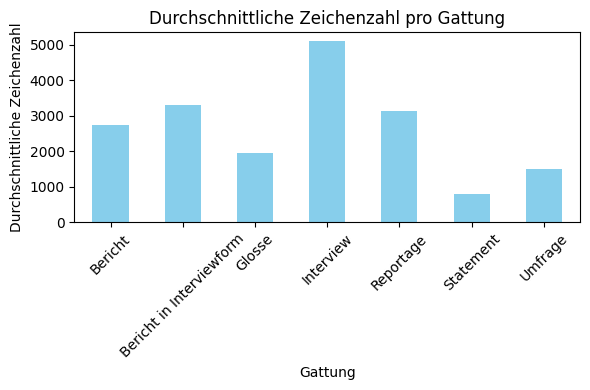

In [11]:
char_count_by_category = df.groupby("gattung")["char_count"].agg("mean").round(0)
plot_count_by_category(char_count_by_category, "Durchschnittliche Zeichenzahl")

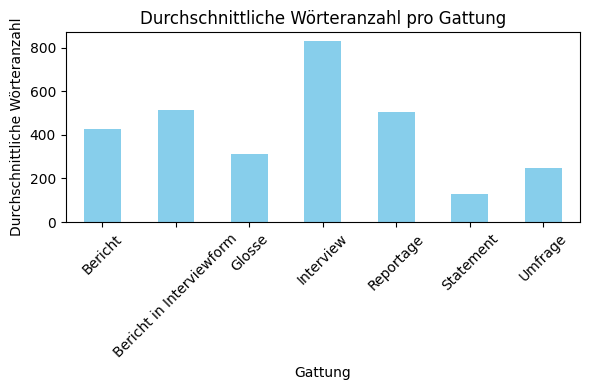

In [12]:
word_count_by_category = df.groupby("gattung")["word_count"].agg("mean").round(0)
plot_count_by_category(word_count_by_category, "Durchschnittliche Wörteranzahl")

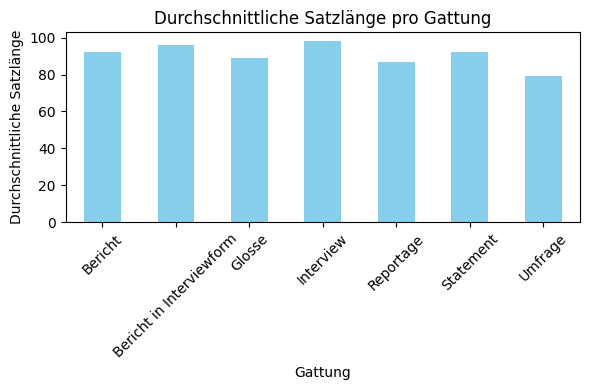

In [49]:
sentence_length_by_category = df.groupby("gattung")["avr_sentence_length"].agg("mean").round(0)
plot_count_by_category(sentence_length_by_category, "Durchschnittliche Satzlänge")

[Text(0.5, 0, 'word count'),
 Text(0, 0.5, 'Average sentence length'),
 Text(0.5, 1.0, 'Word Count vs. Satzlänge (nach Gattung)')]

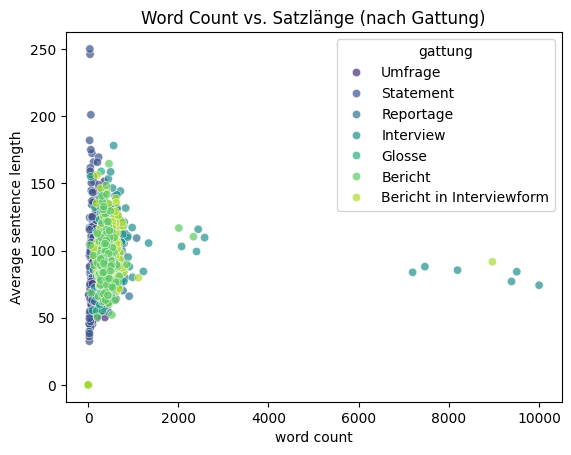

In [13]:
ax = sns.scatterplot(
    data=df,
    x='word_count',
    y='avr_sentence_length',
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='viridis',
    alpha=0.7
)
ax.set(xlabel="word count", ylabel="Average sentence length", title='Word Count vs. Satzlänge (nach Gattung)')

Hier gibt es einige üble Ausreißer, wie damit umgehen?

1. Kürze das Transcript überlanger Texte auf die Durchschnittslänge der jeweiligen Kategorie

In [14]:
def truncate_long_text(text, category):
    words = text.split(" ")
    if len(words) < 3000:
        return text
    else:
        return " ".join(words[:word_count_by_category[category].astype(int)])

df["transcript"] = df.apply(lambda row: truncate_long_text(row["transcript"],row["gattung"]), axis=1)
df["word_count"] = df["transcript"].apply(word_count)
df["char_count"] = df["transcript"].apply(char_count)
df["avr_sentence_length"] = df["transcript"].apply(avr_sentence_length)

[Text(0.5, 0, 'word count'),
 Text(0, 0.5, 'avarage sentence length'),
 Text(0.5, 1.0, 'Word Count vs. Satzlänge (nach Gattung)')]

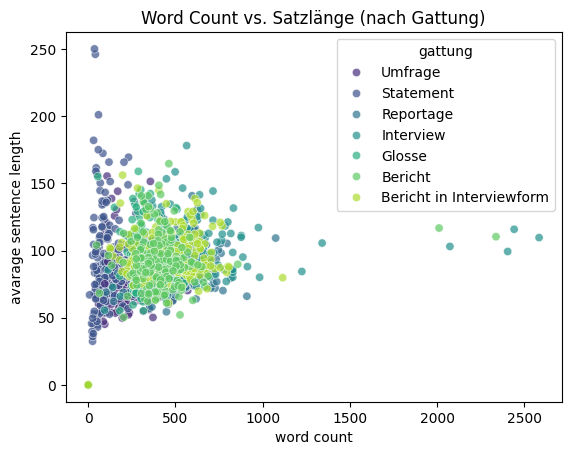

In [15]:
# Scatterplot mit Seaborn (handhabt Kategorien automatisch)
ax = sns.scatterplot(
    data=df,
    x='word_count',
    y='avr_sentence_length',
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='viridis',
    alpha=0.7
)
ax.set(xlabel="word count", ylabel="avarage sentence length", title='Word Count vs. Satzlänge (nach Gattung)')

Besser! Betrachte die Ausreißer auf der Y-Achse

In [16]:
df[df["avr_sentence_length"] > 220]

,transcript,gattung,embedding,word_count,char_count,avr_sentence_length
240,Ich hatte wirklich einfach starke Probleme mit...,Statement,"0.041820656508207, 0.015210284851491002, -0.01...",42,246,246.0
334,Jetzt haben wir einen Geisterkrankenhaus daste...,Statement,"-0.008378626778721001, 0.033959086984395, -0.0...",37,250,250.0


In [17]:
df.iloc[240]["transcript"]

'Ich hatte wirklich einfach starke Probleme mit den Lungen und von daher bin ich unheimlich stolz auf meine Leistung, weil ich denke, das muss erst mal jemand schaffen, so gehandicapt an den Start zu gehen und dann noch eine Silbermedaille da raus'

Liegt vermutlich am vermehrten Rauschen im Transkript von Statement (keine geübten Sprecher*innen). Ich lasse es erstmal so.

In [18]:
small_sentence_length = df[df["avr_sentence_length"] < 25]
small_sentence_length.head()

,transcript,gattung,embedding,word_count,char_count,avr_sentence_length
227,,Statement,"-0.030148252844810004, -0.005122783593833001, ...",1,0,0.0
228,,Statement,"-0.030148252844810004, -0.005122783593833001, ...",1,0,0.0
255,,Statement,"-0.030148252844810004, -0.005122783593833001, ...",1,0,0.0
626,,Interview,"-0.030148252844810004, -0.005122783593833001, ...",1,0,0.0
628,,Interview,"-0.030148252844810004, -0.005122783593833001, ...",1,0,0.0


Hier liegen die Dinge ohne Mining-Transkript. Die müssen entfernt werden:

In [19]:
df = df.drop(small_sentence_length.index).copy()
df.shape

(1343, 6)

[Text(0.5, 0, 'word count'),
 Text(0, 0.5, 'avarage sentence length'),
 Text(0.5, 1.0, 'Word Count vs. Satzlänge (nach Gattung)')]

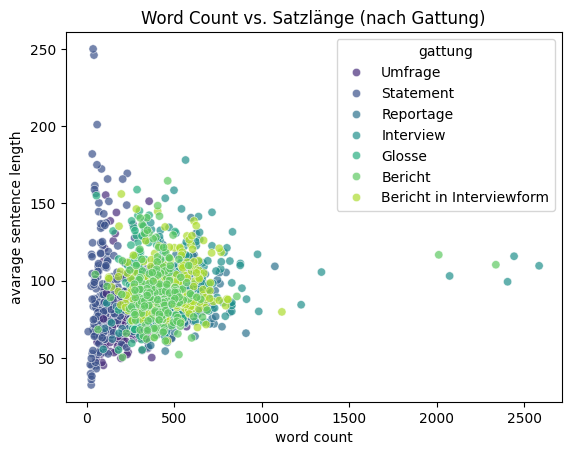

In [20]:
# Scatterplot mit Seaborn (handhabt Kategorien automatisch)
ax = sns.scatterplot(
    data=df,
    x='word_count',
    y='avr_sentence_length',
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='viridis',
    alpha=0.7
)
ax.set(xlabel="word count", ylabel="avarage sentence length", title='Word Count vs. Satzlänge (nach Gattung)')

Besser! Jetzt das transcript entschlacken

In [21]:
def clean(text):
    text = str(text).lower()
    text = re.sub("-"," ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

df["clean_text"] = df["transcript"].apply(clean)
df.loc[1]["clean_text"]

'he ute ist weltknuddeltag was es nicht alles gibt weltknuddeltag existiert schon seit 38 jahren und wurde ins leben gerufen und leuten vor augen zu führen wie wichtig so eine kurze umarmung so ein kurzes knuddeln fürs wohlbefinden sein kann unser reporter jens alenia hat nachgehakt und gefragt wann haben sie denn das letzte mal geknuddelt und wen mein mann meine freundin mein freund ist knüller mir von meiner oma mutter vater tante cousine großtante da kommt es ja aus dem knuddel nicht mehr raus das ist auch gut so meine freundin deren mann knuddel ist wie knuddeln den mann ihrer freunde ja natürlich wir sind uns sehr lange vertraute freunde ein bisschen körperkontakt muss schon sein auf jeden fall also schob ein teddybär den ich gern knuddele jeden abend eine bettdecke gibt es irgendeine bekannte persönlichkeit die sie ger ne mal knuddeln würden j taylor swift justin timberlake vielleicht denen würde ich knuddeln ja alle so süß ist ich glaub fremde leute knuddelt ich gar nicht so ger

**Stopwörter entfernen**

In [22]:
stop_words = stopwords.get_stopwords("de")

def remove_stopwords(text):
    return " ".join([word for word in text.split(" ") if word not in stop_words])

df["text_stopwordless"] = df["clean_text"].apply(remove_stopwords)
df.head()

,transcript,gattung,embedding,word_count,char_count,avr_sentence_length,clean_text,text_stopwordless
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,"0.015333812683820001, 0.021696707233786, -0.07...",262,1643,73.73,vor der letzten bundestagswahl waren sie absol...,letzten bundestagswahl waren absolut umfrageho...
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,"0.033938158303499, -0.058570936322212004, -0.0...",290,1759,66.69,he ute ist weltknuddeltag was es nicht alles g...,he ute weltknuddeltag alles gibt weltknuddelta...
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,"0.08172919601202, -0.06428052484989101, 0.0208...",222,1323,59.18,47 elf grrrls wasser ja hat meine mutter immer...,47 elf grrrls wasser hat mutter immer gekauft ...
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,"0.045513272285461, 0.023429902270436002, -0.06...",115,702,77.11,ja meint die atmosphäre im endeffekt gehört di...,meint atmosphäre endeffekt gehört leute allem ...
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,"0.034393869340419006, -0.038432110100984004, -...",333,2062,67.77,gestern abend großes familienfest vielleicht d...,gestern abend großes familienfest vielleicht i...


**Tokenisieren**

In [2]:
#!python -m spacy download de_core_news_md

In [25]:
nlp = spacy.load('de_core_news_md')

In [26]:
def tokenize(text):
    doc = nlp(text)
    tokens = [tok.text for tok in doc]
    return tokens

df["tokens"] = df["transcript"].progress_apply(tokenize)
df.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1343/1343 [01:41<00:00, 13.27it/s]


,transcript,gattung,embedding,word_count,char_count,avr_sentence_length,clean_text,text_stopwordless,tokens
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,"0.015333812683820001, 0.021696707233786, -0.07...",262,1643,73.73,vor der letzten bundestagswahl waren sie absol...,letzten bundestagswahl waren absolut umfrageho...,"[Vor, der, letzten, Bundestagswahl, waren, sie..."
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,"0.033938158303499, -0.058570936322212004, -0.0...",290,1759,66.69,he ute ist weltknuddeltag was es nicht alles g...,he ute weltknuddeltag alles gibt weltknuddelta...,"[He, ute, ist, Weltknuddeltag, ,, was, es, nic..."
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,"0.08172919601202, -0.06428052484989101, 0.0208...",222,1323,59.18,47 elf grrrls wasser ja hat meine mutter immer...,47 elf grrrls wasser hat mutter immer gekauft ...,"[47, elf, ,, Grrrls, Wasser, ja, ,, hat, meine..."
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,"0.045513272285461, 0.023429902270436002, -0.06...",115,702,77.11,ja meint die atmosphäre im endeffekt gehört di...,meint atmosphäre endeffekt gehört leute allem ...,"[Ja, ,, meint, die, Atmosphäre, ., Im, Endeffe..."
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,"0.034393869340419006, -0.038432110100984004, -...",333,2062,67.77,gestern abend großes familienfest vielleicht d...,gestern abend großes familienfest vielleicht i...,"[Gestern, Abend, großes, Familienfest, ,, viel..."


**Lemmatisieren**

In [27]:
def lemmatize(text):
     doc = nlp(text)
     return " ".join([x.lemma_ for x in doc])

df["text_lemmatized"] = df["text_stopwordless"].progress_apply(lemmatize)
df.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1343/1343 [00:53<00:00, 25.32it/s]


,transcript,gattung,embedding,word_count,char_count,avr_sentence_length,clean_text,text_stopwordless,tokens,text_lemmatized
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,"0.015333812683820001, 0.021696707233786, -0.07...",262,1643,73.73,vor der letzten bundestagswahl waren sie absol...,letzten bundestagswahl waren absolut umfrageho...,"[Vor, der, letzten, Bundestagswahl, waren, sie...",letzter Bundestagswahl sein absolut Umfragehoc...
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,"0.033938158303499, -0.058570936322212004, -0.0...",290,1759,66.69,he ute ist weltknuddeltag was es nicht alles g...,he ute weltknuddeltag alles gibt weltknuddelta...,"[He, ute, ist, Weltknuddeltag, ,, was, es, nic...",he ute Weltknuddeltag alle geben Weltknuddelta...
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,"0.08172919601202, -0.06428052484989101, 0.0208...",222,1323,59.18,47 elf grrrls wasser ja hat meine mutter immer...,47 elf grrrls wasser hat mutter immer gekauft ...,"[47, elf, ,, Grrrls, Wasser, ja, ,, hat, meine...",47 elf grrrls Wasser haben Mutter immer kaufen...
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,"0.045513272285461, 0.023429902270436002, -0.06...",115,702,77.11,ja meint die atmosphäre im endeffekt gehört di...,meint atmosphäre endeffekt gehört leute allem ...,"[Ja, ,, meint, die, Atmosphäre, ., Im, Endeffe...",meinen Atmosphäre Endeffekt gehören leute alle...
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,"0.034393869340419006, -0.038432110100984004, -...",333,2062,67.77,gestern abend großes familienfest vielleicht d...,gestern abend großes familienfest vielleicht i...,"[Gestern, Abend, großes, Familienfest, ,, viel...",gestern abend groß Familienfest vielleicht ihn...


**Hier kann man den Dataframe direkt laden, um sich in Zukunft das Preprocessing zu sparen!**

In [4]:
# load dataframe to save time
try:
    df.to_pickle("lemmatized.pkl")
except:
    df = pd.read_pickle("lemmatized.pkl")

#df = pd.read_pickle("lemmatized.pkl")

## Test verschiedener Modelle

Hier wird ein Bag of Words Ansatz versucht. Es macht einen erheblichen Unterschied, wie der max_features Wert bei der Vektorisierung gewählt wird, auch abhängig vom Modell. Tendenziell zeigt sich, dass die Ergebnisse etwas besser werden, wenn man die Stopwords drin lässt.

**BoW erstellen und mit PCA analysieren:**

In [5]:
vectorizer = CountVectorizer(max_features=4000)

X = vectorizer.fit_transform(df["clean_text"])

import matplotlib.pyplot as plt

# PCA durchführen (auf 2D reduzieren)
svd = TruncatedSVD(n_components=2, random_state=42)
# pca = PCA(n_components=2)
X_pca = svd.fit_transform(X)  # X_count_vectorized = Ihre transformierten Daten

[Text(0.5, 1.0, 'Vektorraum mit TruncatedSVD/PCA')]

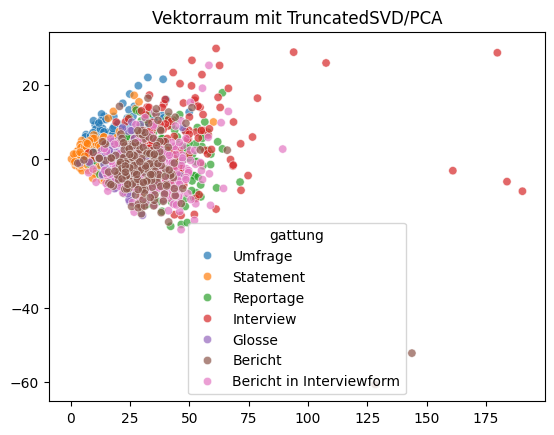

In [6]:
ax = sns.scatterplot(
    data=df,
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='tab10',
    alpha=0.7
)
ax.set(title = "Vektorraum mit TruncatedSVD/PCA")

What a mess!

In [7]:

# t-SNE anwenden (auf 2D reduzieren)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

C:\Users\janfs\Projekte\Python Projekte\2015 nlp-genres\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[Text(0.5, 1.0, 'Vektorraum mit TruncatedSVD/PCA')]

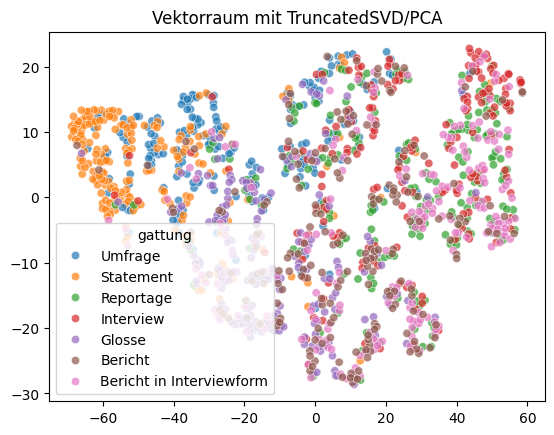

In [8]:
ax = sns.scatterplot(
    data=df,
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='tab10',
    alpha=0.7
)
ax.set(title = "Vektorraum mit TruncatedSVD/PCA")

Witzig, aber ohne wirkliche Cluster

## Bag of Words

### BoW + Naive Bayes

In [9]:
vectorizer = CountVectorizer(max_features=4000)

X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", model.score(X_train, y_train))
print("Genauigkeit Testset:", model.score(X_test, y_test))

Genauigkeit Trainingsset: 0.9320297951582868
Genauigkeit Testset: 0.5910780669144982


Overfitting!

### BoW + Logistic Regression

In [10]:

vectorizer = CountVectorizer(max_features=8000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(multi_class='ovr', max_iter=10000)
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", model.score(X_train, y_train))
print("Genauigkeit Testset:", model.score(X_test, y_test))

C:\Users\janfs\Projekte\Python Projekte\2015 nlp-genres\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Genauigkeit Trainingsset: 1.0
Genauigkeit Testset: 0.6654275092936803


Overfitting!

### BoW + Support Vector Machines

In [11]:


vectorizer = CountVectorizer(max_features=8000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

# model = SVC(kernel='linear', C=1.0)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Genauigkeit: {accuracy}")

Beste Parameter: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Bester Score: 0.6201117318435755


In [12]:
model = SVC(C=10, gamma="scale", kernel="rbf")
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", model.score(X_train, y_train))
print("Genauigkeit Testset:", model.score(X_test, y_test))

Genauigkeit Trainingsset: 0.9916201117318436
Genauigkeit Testset: 0.7211895910780669


Immer noch ein bisschen Overfitting, aber besser

### BoW + Decision Tree

In [13]:

vectorizer = CountVectorizer(max_features=2000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", dt_classifier.score(X_train, y_train))
print("Genauigkeit Testset:", dt_classifier.score(X_test, y_test))

Genauigkeit Trainingsset: 1.0
Genauigkeit Testset: 0.4163568773234201


Overfitting!

### BoW + Random Forest

In [14]:

vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vorher: DecisionTreeClassifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,  # Anzahl Bäume
    max_depth=None,     # Begrenzt Baumtiefe
    random_state=42,
    n_jobs=-1          # Nutzt alle CPU-Kerne
)
rf_classifier.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", rf_classifier.score(X_train, y_train))
print("Genauigkeit Testset:", rf_classifier.score(X_test, y_test))

Genauigkeit Trainingsset: 1.0
Genauigkeit Testset: 0.6505576208178439


Overfitting!

In [15]:
param_grid = {
    'n_estimators': [200,300,400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None]
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=3, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300, 400]},
             verbose=1)

In [16]:
print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

Beste Parameter: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 400}
Bester Score: 0.5996275605214153


In [17]:
# Vorher: DecisionTreeClassifier
rf_classifier_best_params = RandomForestClassifier(
    n_estimators=300,  # Anzahl Bäume
    max_depth=None,     # Begrenzt Baumtiefe
    random_state=42,
    n_jobs=-1,          # Nutzt alle CPU-Kerne
    max_features="sqrt",
)
rf_classifier_best_params.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", rf_classifier_best_params.score(X_train, y_train))
print("Genauigkeit Testset:", rf_classifier_best_params.score(X_test, y_test))

Genauigkeit Trainingsset: 1.0
Genauigkeit Testset: 0.6728624535315985


Overfitting

### TF-IDF + Naive Bayes

In [59]:
# TF-IDF statt reinen Wortzählens
vectorizer = TfidfVectorizer(max_features=2000)  # 👈 Geändert
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Genauigkeit Trainingsset", model.score(X_train, y_train))
print("Genauigkeit Testset", model.score(X_test, y_test))

Genauigkeit Trainingsset 0.7942271880819367
Genauigkeit Testset 0.5464684014869888
Genauigkeit: 0.5464684014869888


### TF-IDF + Logistic Regreggion

In [62]:

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(multi_class='ovr', max_iter=10000)
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset", model.score(X_train, y_train))
print("Genauigkeit Testset", model.score(X_test, y_test))

Genauigkeit Trainingsset 0.8463687150837989
Genauigkeit Testset 0.6728624535315985


C:\Users\janfs\Projekte\Python Projekte\2015 nlp-genres\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


### TF-IDF + SVM

In [34]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Beste Parameter: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Bester Score: 0.6452513966480447


In [65]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SVC(C=1, gamma="scale", kernel="linear")
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset", model.score(X_train, y_train))
print("Genauigkeit Testset", model.score(X_test, y_test))

Genauigkeit Trainingsset 0.9813780260707635
Genauigkeit Testset 0.7063197026022305


### TF-IDF + Random Forest

In [67]:

vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vorher: DecisionTreeClassifier
model = RandomForestClassifier(
    n_estimators=100,  # Anzahl Bäume
    max_depth=None,     # Begrenzt Baumtiefe
    random_state=42,
    n_jobs=-1          # Nutzt alle CPU-Kerne
)
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset", model.score(X_train, y_train))
print("Genauigkeit Testset", model.score(X_test, y_test))

Genauigkeit Trainingsset 1.0
Genauigkeit Testset 0.6319702602230484


In [36]:
param_grid = {
    'n_estimators': [200,300,400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None]
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=3, verbose=1)
grid_search.fit(X_train, y_train)

print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Beste Parameter: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 400}
Bester Score: 0.6238361266294228


Wir haben hier bei den meisten Modellen ein Overfitting-Problem. Versuche es mit Dimensionsreduktion/Topic Modeling zu lösen, wie im Buch "Natural Language Processing in Action" beschrieben

## Dimensionsreduktion/Topic Modelling

In [18]:

# Bag of Words schnüren
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["text_stopwordless"])
y = df['gattung']

svd = TruncatedSVD(n_components=64, n_iter=100) 
columns = ['topic{}'.format(i) for i in range(svd.n_components)]
svd_topic_vectors = svd.fit_transform(X)

In [19]:
# hier sind die 16 Topics, die der Algorithmus identifiziert hat, als Dataframe
df_svd_topic_vectors = pd.DataFrame(svd_topic_vectors, columns=columns)
df_svd_topic_vectors

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic54,topic55,topic56,topic57,topic58,topic59,topic60,topic61,topic62,topic63
0,4.169890,-1.437824,-0.270297,-1.336581,-0.600724,0.175579,-0.182710,-0.269423,0.903040,-1.169538,...,-0.406005,-0.411406,0.131178,0.293938,-0.203964,-0.407468,-0.004974,-0.224080,-0.442080,0.284514
1,9.679166,0.839887,1.270819,6.773034,-1.576390,-2.917480,-1.743300,-1.070600,-1.538704,-0.237217,...,-0.388804,-0.197665,-0.711744,-0.926176,1.271631,0.005705,-0.168405,-0.401007,0.174342,-0.892681
2,8.790604,-2.080179,-3.992840,-0.456240,0.199399,1.456615,0.888769,-1.536743,-1.095746,2.008344,...,-0.530666,0.668244,0.198531,-0.988242,0.703504,-0.567364,-0.147274,-0.238248,0.540709,-0.606617
3,3.630929,0.364102,1.452645,1.923465,-0.789587,0.978202,-0.987767,0.514079,-1.057032,0.391751,...,0.092674,0.286799,-0.985477,-0.139710,0.493238,-0.283245,0.457776,-0.037057,-0.031301,0.117571
4,11.043187,-4.667889,-0.656037,-0.780865,-2.093789,0.354931,0.409724,-1.123104,0.909396,1.708353,...,-1.875708,-0.287852,0.517629,0.664859,-0.584091,-0.323029,1.061411,0.164397,0.287331,-0.713055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,5.076468,1.573684,1.441802,-0.927944,0.599626,1.954665,0.072098,-1.062188,0.003128,-0.190476,...,-0.028929,0.386352,0.410926,-0.017395,-0.162623,-0.457035,-0.245992,-0.655905,-0.266787,0.246644
1339,9.103117,-1.884825,0.977555,-1.632714,-1.149797,2.774365,0.615557,3.145101,1.306147,3.667843,...,0.707247,1.565122,-0.232380,0.015536,0.698050,0.413995,0.212352,0.122967,0.205882,1.184740
1340,10.940305,-1.250646,2.527555,-1.493650,1.279220,1.328641,-0.233947,3.900004,0.034475,1.579472,...,-0.143851,0.662256,-0.493330,0.323004,0.722488,0.134027,-1.391613,-0.434617,-2.075855,2.046980
1341,4.146989,-1.442990,-0.989048,0.767899,0.179447,-0.414223,0.134348,-0.694028,-0.695298,0.067638,...,0.324890,-0.336580,0.421640,0.037704,-0.099013,-0.375886,-0.131448,0.619893,0.163692,0.262409


In [20]:
# hier werden die Terme aus dem Bag of Words angezeigt
column_nums, terms = zip(*sorted(zip(vectorizer.vocabulary_.values(), vectorizer.vocabulary_.keys()))) 
terms[-10:]

('überwinden',
 'überwindung',
 'überzeugen',
 'überzeugt',
 'überzeugung',
 'üblichen',
 'übrig',
 'übrigens',
 'übung',
 'übungen')

In [21]:
# Hier wird aus den BoW Termen und svd componenten eine Tabelle gestrickt. In der sieht man, wie viel jeder Term zu jedem Topic beiträgt.
topic_term_matrix = pd.DataFrame(svd.components_, columns=terms, index=['topic{}'.format(i) for i in range(64)])
topic_term_matrix.head()

,10,100,1000,10000,11,12,120,1200,13,14,...,überwinden,überwindung,überzeugen,überzeugt,überzeugung,üblichen,übrig,übrigens,übung,übungen
topic0,0.001963,0.002325,0.000779,0.000427,0.000909,0.001133,0.000878,0.000583,0.003001,0.005793,...,0.000447,0.000803,0.000703,0.001854,0.000620,0.000960,0.001155,0.008640,0.000953,0.000514
topic1,0.002323,-0.005851,0.000289,0.000546,0.001159,-0.000795,0.001559,-0.000643,-0.001486,-0.006266,...,0.000565,-0.000201,0.000656,-0.000658,0.000627,0.002146,-0.001092,-0.019309,0.000498,0.001294
topic2,-0.001566,0.005491,0.001459,0.001542,0.001338,0.000282,0.002835,-0.000988,-0.001206,0.000803,...,-0.000563,-0.002174,-0.000452,-0.000400,-0.002778,-0.000982,0.001409,0.000699,0.002121,-0.000959
topic3,-0.000584,-0.000399,-0.002022,0.000645,-0.001094,-0.000775,-0.001356,-0.002120,-0.000776,-0.003757,...,0.000178,0.002342,-0.001535,-0.002415,-0.003366,-0.004316,-0.000244,0.005486,0.000699,0.000501
topic4,-0.000281,0.002545,0.001155,0.002186,-0.001747,0.000223,0.002157,-0.000734,0.001951,-0.001376,...,0.000492,0.000074,-0.001528,-0.000246,-0.002044,-0.000683,-0.000914,0.007661,-0.001708,0.001336


In [22]:
# ... hier einzelne Wörter ausprobieren
# topic_term_matrix["interview"]

In [23]:
# und die performance?
X_train_16d, X_test_16d, y_train_16d, y_test_16d = train_test_split(df_svd_topic_vectors, 
                                                                    y, 
                                                                    test_size=0.2, 
                                                                    random_state=42)


In [24]:
lda_lsa = LinearDiscriminantAnalysis(n_components=1)
model = lda_lsa.fit(X_train_16d, y_train_16d)

In [25]:
print("Genauigkeit Trainingsset:", model.score(X_train_16d, y_train_16d))
print("Genauigkeit Testset:", model.score(X_test_16d, y_test_16d))

Genauigkeit Trainingsset: 0.6824953445065177
Genauigkeit Testset: 0.5947955390334573


Das hat nicht so gut geklappt. Versuchen wir das SVD-Modell von oben

In [26]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_16d, y_train_16d)

print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

Beste Parameter: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Bester Score: 0.5931098696461826


In [27]:
model = SVC(C=1, gamma="scale", kernel="rbf")
model.fit(X_train_16d, y_train_16d)

print("Genauigkeit Trainingsset:", model.score(X_train_16d, y_train_16d))
print("Genauigkeit Testset:", model.score(X_test_16d, y_test_16d))

Genauigkeit Trainingsset: 0.7886405959031657
Genauigkeit Testset: 0.6171003717472119


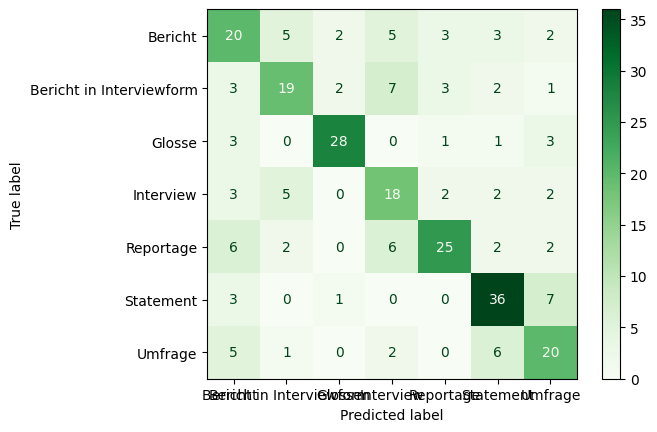

In [28]:
# ... Matrix erstellen
y_pred = model.predict(X_test_16d)
cm = confusion_matrix(y_test_16d, y_pred)

# ... und visualisieren
class_names = np.unique(y_test_16d)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Greens')
plt.show()

versuchen wir es nochmal mit tf-idf

In [29]:
vectorizer = TfidfVectorizer(max_features=4000)
X = vectorizer.fit_transform(df["clean_text"])
y = df['gattung']

svd = TruncatedSVD(n_components=64, n_iter=100) 
columns = ['topic{}'.format(i) for i in range(svd.n_components)]
svd_topic_vectors = svd.fit_transform(X)

df_svd_topic_vectors = pd.DataFrame(svd_topic_vectors, columns=columns)
df_svd_topic_vectors

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic54,topic55,topic56,topic57,topic58,topic59,topic60,topic61,topic62,topic63
0,0.418902,-0.050397,-0.049013,0.015578,-0.046732,0.038827,0.036475,0.010366,0.000374,0.034246,...,-0.099168,0.082583,0.053464,-0.062455,0.053850,0.006253,-0.005943,-0.037905,0.030754,0.053108
1,0.318213,0.145437,0.022726,0.034103,0.007615,-0.042461,-0.013734,0.049171,0.035600,-0.065737,...,-0.012925,0.058758,-0.027295,0.006526,0.031751,-0.001910,0.007848,-0.005099,0.008541,0.045424
2,0.416282,0.114980,-0.074758,-0.043827,-0.016741,0.078877,-0.024363,0.097579,-0.039598,-0.152259,...,-0.063516,-0.019875,-0.070389,-0.012765,-0.024254,0.009126,0.019633,-0.016621,-0.023328,0.047368
3,0.387205,-0.063539,0.048778,0.077264,0.028482,0.134662,-0.073201,-0.094215,0.079055,-0.147222,...,0.071224,0.057769,-0.014511,-0.020279,-0.029662,0.034951,-0.071034,0.009210,-0.045252,-0.031764
4,0.468383,0.077887,-0.052491,-0.061149,0.085670,-0.046261,0.036495,0.063507,0.009276,-0.115190,...,-0.062537,-0.089180,-0.043741,0.050334,-0.005744,-0.028775,-0.075213,0.001858,-0.007928,-0.001192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,0.401439,-0.051477,0.097374,0.066333,0.034264,-0.024290,-0.007373,0.087347,0.080479,-0.012421,...,0.022568,-0.014867,0.004082,-0.030724,0.012759,-0.020464,0.001154,-0.021544,0.018293,0.011667
1339,0.479846,0.098850,-0.019819,0.049798,-0.058165,0.011683,0.099636,0.024732,0.048708,0.034192,...,0.040965,0.004271,-0.001323,-0.074125,0.030600,0.045072,-0.035129,0.026284,0.033171,-0.013632
1340,0.584733,0.036965,0.031988,0.008520,-0.060758,0.017314,0.045147,-0.157215,0.067096,0.005436,...,-0.041852,-0.004378,-0.046992,0.062979,0.002766,-0.036631,0.044967,-0.038127,0.051344,0.034222
1341,0.322171,0.019969,-0.084451,-0.120406,-0.000671,-0.047928,0.020706,0.036179,-0.067210,0.023210,...,0.021300,-0.019365,0.018058,0.019743,-0.001838,0.040893,0.032734,-0.014842,0.013995,-0.028844


In [30]:
X_train_16d, X_test_16d, y_train_16d, y_test_16d = train_test_split(df_svd_topic_vectors, 
                                                                    y, 
                                                                    test_size=0.2, 
                                                                    random_state=42)

lda_lsa = LinearDiscriminantAnalysis(n_components=6)
model = lda_lsa.fit(X_train_16d, y_train_16d)

print("Genauigkeit Trainingsset:", model.score(X_train_16d, y_train_16d))
print("Genauigkeit Testset:", model.score(X_test_16d, y_test_16d))

Genauigkeit Trainingsset: 0.7346368715083799
Genauigkeit Testset: 0.7026022304832714


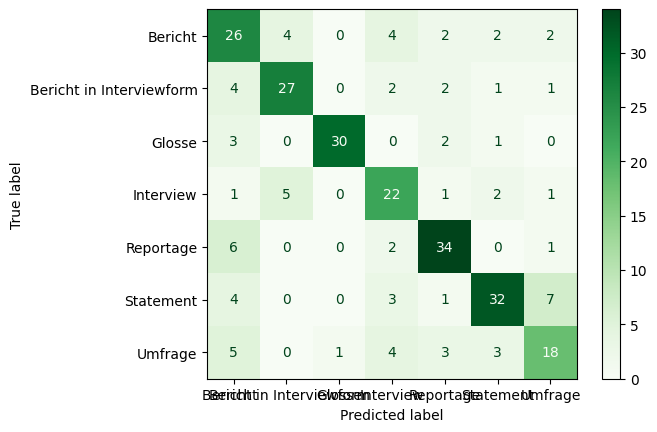

In [31]:
# ... Matrix erstellen
y_pred = model.predict(X_test_16d)
cm = confusion_matrix(y_test_16d, y_pred)

# ... und visualisieren
class_names = np.unique(y_test_16d)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Greens')
plt.show()

Mit tf-idf funktioniert es tatsächlich deutlich besser. Habe den bisher besten Wert erreicht, der sich bereits den llm Ergebnissen annähert. 

### Latent Dirichlet Allocation

In [55]:
# Bag of Words schnüren

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import LatentDirichletAllocation as LDiA


vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["text_lemmatized"])
y = df['gattung']

ldia = LDiA(n_components=200, learning_method='batch')
ldia = ldia.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(ldia, y, test_size=0.2, random_state=42)

model = LinearDiscriminantAnalysis(n_components=None)
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.5549348230912476
0.34944237918215615


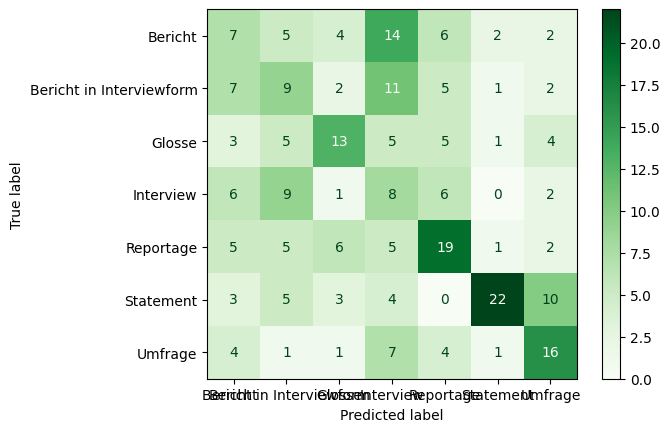

In [56]:
# ... Matrix erstellen
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# ... und visualisieren
class_names = np.unique(y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Greens')
plt.show()

Eher nicht!

## Embeddings

In [76]:
df['embedding_floats'] = df['embedding'].str.strip().str.split(',').apply(
    lambda x: [float(i) for i in x]
)

In [77]:
embeddings = np.vstack(df['embedding_floats'].values)

In [79]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)
df["embedding_pca_x"] = embeddings_2d[:, 0]
df["embedding_pca_y"] = embeddings_2d[:, 1]

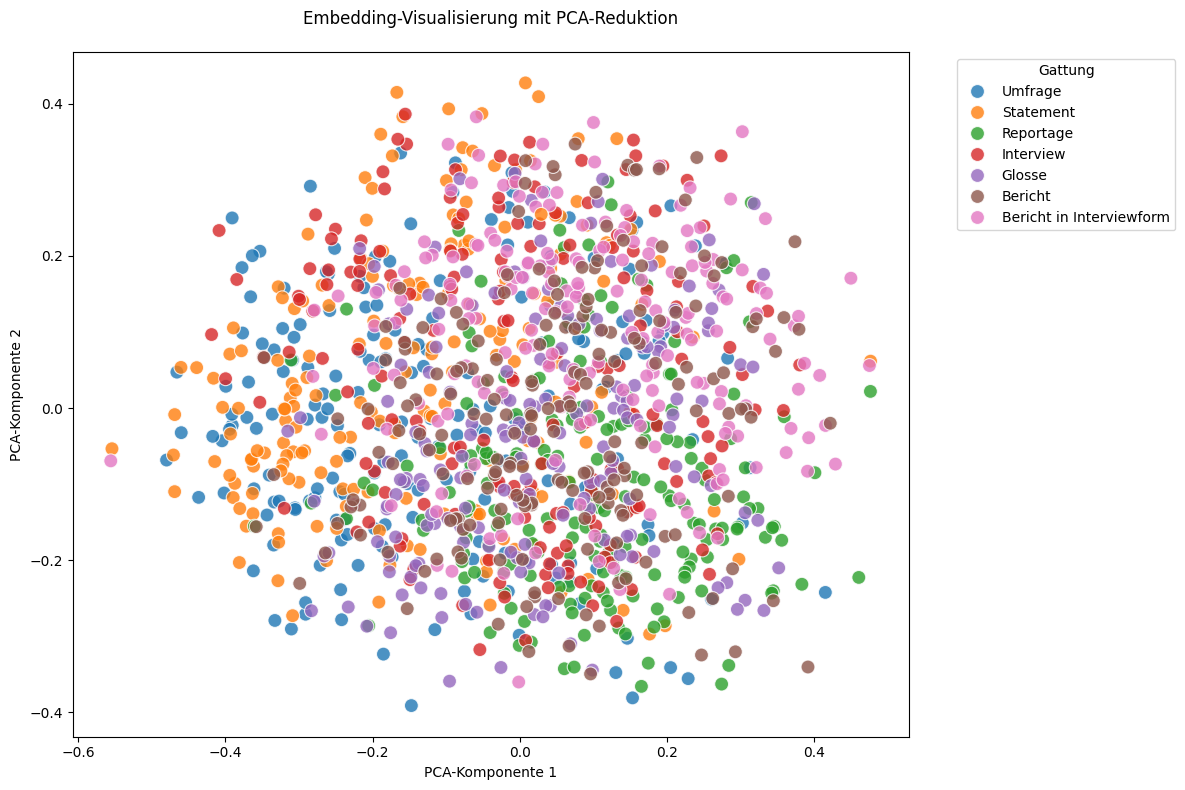

In [82]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='embedding_pca_x',
    y='embedding_pca_y',
    hue='gattung',
    palette='tab10',
    alpha=0.8,
    s=100,
    edgecolor='w'
)

plt.title('Embedding-Visualisierung mit PCA-Reduktion', pad=20)
plt.xlabel('PCA-Komponente 1')
plt.ylabel('PCA-Komponente 2')
plt.legend(bbox_to_anchor=(1.05, 1), title='Gattung')
plt.tight_layout()
plt.show()

Shit!

In [86]:
from sklearn.manifold import TSNE

# T-SNE mit typischen Einstellungen für Text-Embeddings
tsne = TSNE(
    n_components=2,
    perplexity=30,        # Testen Sie Werte zwischen 5-50
    learning_rate=200,   # Für kleinere Datensätze oft höher
    random_state=42,     # Reproduzierbarkeit
    init='pca'           # Bessere Initialisierung
)

embeddings_tsne = tsne.fit_transform(embeddings)

# Ergebnisse speichern
df["embedding_tsne_x"] = embeddings_tsne[:, 0]
df["embedding_tsne_y"] = embeddings_tsne[:, 1]

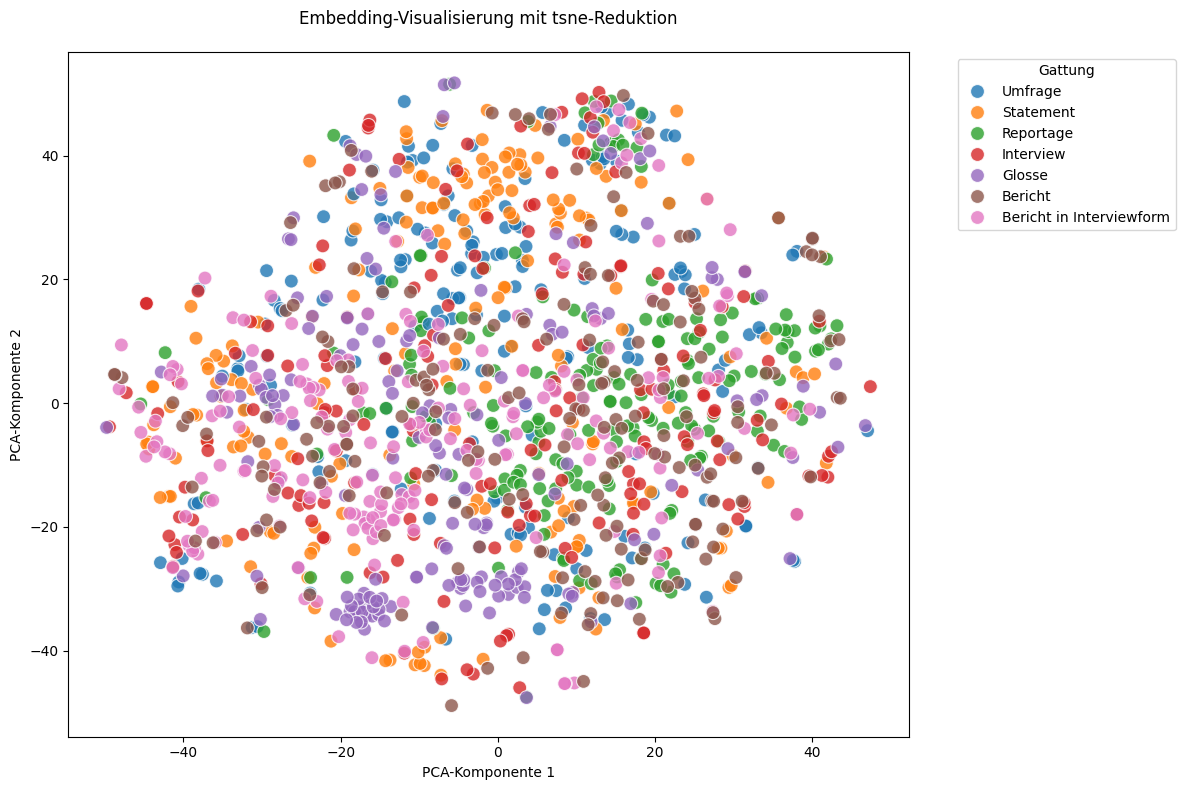

In [88]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='embedding_tsne_x',
    y='embedding_tsne_y',
    hue='gattung',
    palette='tab10',
    alpha=0.8,
    s=100,
    edgecolor='w'
)

plt.title('Embedding-Visualisierung mit tsne-Reduktion', pad=20)
plt.xlabel('PCA-Komponente 1')
plt.ylabel('PCA-Komponente 2')
plt.legend(bbox_to_anchor=(1.05, 1), title='Gattung')
plt.tight_layout()
plt.show()

In [89]:
df.head()

,transcript,gattung,embedding,word_count,char_count,avr_sentence_length,clean_text,text_stopwordless,tokens,text_lemmatized,embedding_floats,embedding_pca_x,embedding_pca_y,embedding_tsne_x,embedding_tsne_y
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,"0.015333812683820001, 0.021696707233786, -0.07...",262,1643,73.73,vor der letzten bundestagswahl waren sie absol...,letzten bundestagswahl waren absolut umfrageho...,"[Vor, der, letzten, Bundestagswahl, waren, sie...",letzter Bundestagswahl sein absolut Umfragehoc...,"[0.015333812683820001, 0.021696707233786, -0.0...",0.152809,0.234113,-32.041004,-0.994150
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,"0.033938158303499, -0.058570936322212004, -0.0...",290,1759,66.69,he ute ist weltknuddeltag was es nicht alles g...,he ute weltknuddeltag alles gibt weltknuddelta...,"[He, ute, ist, Weltknuddeltag, ,, was, es, nic...",he ute Weltknuddeltag alle geben Weltknuddelta...,"[0.033938158303499, -0.058570936322212004, -0....",-0.271194,-0.206620,-7.243228,45.217102
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,"0.08172919601202, -0.06428052484989101, 0.0208...",222,1323,59.18,47 elf grrrls wasser ja hat meine mutter immer...,47 elf grrrls wasser hat mutter immer gekauft ...,"[47, elf, ,, Grrrls, Wasser, ja, ,, hat, meine...",47 elf grrrls Wasser haben Mutter immer kaufen...,"[0.08172919601202, -0.06428052484989101, 0.020...",-0.334428,-0.180017,5.496624,18.334984
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,"0.045513272285461, 0.023429902270436002, -0.06...",115,702,77.11,ja meint die atmosphäre im endeffekt gehört di...,meint atmosphäre endeffekt gehört leute allem ...,"[Ja, ,, meint, die, Atmosphäre, ., Im, Endeffe...",meinen Atmosphäre Endeffekt gehören leute alle...,"[0.045513272285461, 0.023429902270436002, -0.0...",-0.066102,-0.270534,16.729895,9.585168
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,"0.034393869340419006, -0.038432110100984004, -...",333,2062,67.77,gestern abend großes familienfest vielleicht d...,gestern abend großes familienfest vielleicht i...,"[Gestern, Abend, großes, Familienfest, ,, viel...",gestern abend groß Familienfest vielleicht ihn...,"[0.034393869340419006, -0.038432110100984004, ...",-0.242037,-0.278186,7.425843,-30.305819


In [93]:
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Daten konvertieren (falls nötig)
# df['embedding'] = df['embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep=','))

# 2. Korrekte Train/Test-Split
X = df[['embedding_floats']]  # Features als DataFrame
y = df['gattung']      # Labels

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

# 3. GroupBy auf TRAIN-Daten mit y_train
train_df = X_train.copy()
train_df['gattung'] = y_train  # Label wieder hinzufügen

centroids = train_df.groupby('gattung')['embedding_floats'].apply(
    lambda x: np.mean(np.vstack(x), axis=0)
).to_dict()

# 4. Vorhersage auf Testdaten
def predict_nearest_label(test_embedding, centroids):
    labels = list(centroids.keys())
    centroid_vectors = np.vstack(list(centroids.values()))
    
    # Wichtig: test_embedding als 2D-Array
    dist_idx = pairwise_distances_argmin_min(
        test_embedding.reshape(1, -1), 
        centroid_vectors
    )[0][0]
    
    return labels[dist_idx]

# Anwendung
X_test['predicted_label'] = X_test['embedding_floats'].apply(
    lambda x: predict_nearest_label(np.array(x), centroids)
)

Model Accuracy: 47.58%

                          precision    recall  f1-score   support

                 Bericht       0.57      0.40      0.47        40
Bericht in Interviewform       0.36      0.43      0.39        37
                  Glosse       0.60      0.67      0.63        36
               Interview       0.12      0.09      0.11        32
               Reportage       0.58      0.77      0.66        43
               Statement       0.56      0.43      0.48        47
                 Umfrage       0.41      0.47      0.44        34

                accuracy                           0.48       269
               macro avg       0.46      0.47      0.45       269
            weighted avg       0.47      0.48      0.47       269



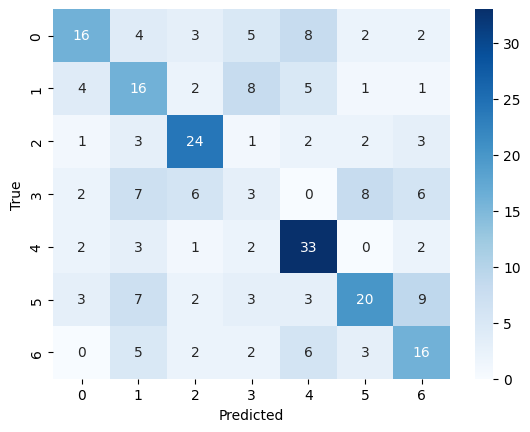

In [94]:
from sklearn.metrics import accuracy_score

# 1. Tatsächliche Labels und Vorhersagen vergleichen
y_true = y_test  # Echte Labels aus dem Testset
y_pred = X_test['predicted_label']  # Vorhergesagte Labels

# 2. Accuracy berechnen
accuracy = accuracy_score(y_true, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

# 3. Optional: Detaillierter Classification Report
from sklearn.metrics import classification_report
print("\n" + classification_report(y_true, y_pred))

# 4. Optional: Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()